In [2]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
import pandas as pd
import pickle as pkl
            import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from notebook_utils import *
from parameter_estimation import load_data_util
import numpy as np
import pandas as pd
import snap
import operator
from sklearn import metrics
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='serif', size='13') # controls default text sizes
plt.rc('xtick', labelsize='12')
plt.rc('ytick', labelsize='12')
plt.rc('legend', fontsize='13') # legend fontsize
plt.rc('axes', labelsize='12', titlesize='13')  # fontsize of the x and y labels # fontsize of the axes title
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



# Clustering ROC and MAE_pi

mae, reqd pi, predicted pi =  0.072 [0.5157894736842106, 0.4842105263157895] [0.5559969 0.4440031]


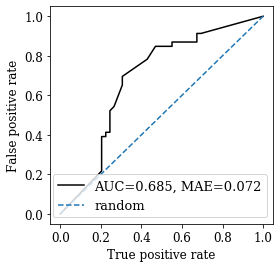

In [2]:
out = 'all_kwon/kwon_copy' 
resp = np.loadtxt('../output/{}/resp.txt'.format(out))
pi = np.loadtxt('../output/{}/pi.txt'.format(out))
fake_comp = 0

# fake component: cluster
if fake_comp == 0:
    pred_prob = 1 - resp[:, 1]
else:
    pred_prob = resp[:, 1]
target = resp[:, 2]

# pi: MAE
_, c = np.unique(target, return_counts=True)
reqd_pi_t, reqd_pi_f = c[0]/len(target), c[1]/len(target)
mae = round(abs(pi[fake_comp] - reqd_pi_f), 3) #  + abs(pi[1 - fake_comp] - reqd_pi_t)) / 2
print('mae, reqd pi, predicted pi = ', mae, [reqd_pi_t, reqd_pi_f], pi)

# plot roc: cluster
fpr, tpr, thresholds = metrics.roc_curve(target, pred_prob, pos_label=1)
auc = round(metrics.roc_auc_score(target, pred_prob), 3)
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(fpr, tpr, 'black', label="AUC={}, MAE={}".format(auc, mae))
ax.plot(fpr, fpr, '--', label="random")
ax.legend(loc=4)
ax.set_xlabel('True positive rate')
ax.set_ylabel('False positive rate')
plt.show()



# -- (cannot) edge recovery: 

In [29]:
# (cascades on follower graph aren't pruned based on the subgraph with > 5 engagements)
# so if a, b, c, d cascade where a to b and a to c. But we get rid of a, and still keep b in subgraph of b, c, d
# follows relation is not retweet relation, but close approx; doesnt account for coordinated external activations
# this dataset - many isolated events, and num of observations per edge can be small. 
# the unobserved diffusion edges can represented abstract concepts that has no correct ground truth.

data = 'kwon'
# retweet graph
rel_links = '../data/{}/rel_links.txt'.format(data)
rldf = pd.read_csv(rel_links, sep=' ', header=None)  # a follows b # retrieve b -> a edges

out = 'all_kwon/kwon_edgesB'
# user index mapping
idx2u = np.loadtxt('../output/{}/idx2u.txt'.format(out))
u2idx = dict(zip(np.array(idx2u, dtype=np.int32), np.arange(len(idx2u))))
raw_cascades = read_cascades_file('../data/{}/cascades.txt'.format(data))
cascades = load_data_util._convert_cascades_by_index(raw_cascades, u2idx)
UV = np.zeros((len(idx2u), len(idx2u)))
# u before v in any cascade = 1
for cas in cascades:
    if len(cas) == 0: continue
    for i, u in enumerate(cas[:, 0]):
        v_users = np.array(cas[i+1:, 0], dtype=np.int32)
        UV[int(u)][v_users] = 1

# gt edges graph
filtered_rldf = rldf[rldf[0].isin(idx2u) & rldf[1].isin(idx2u)]
gt_graph = snap.PNEANet.New()
for user in range(len(idx2u)):
    gt_graph.AddNode(int(user))
for i, row in filtered_rldf.iterrows():
    a, b = int(u2idx[row[0]]), int(u2idx[row[1]]) 
    if UV[b][a] == 1:  # i.e. time_dict[b] < time_dict[a] in any cascade
        gt_graph.AddEdge(b, a)
print('gt_graph created', gt_graph.GetNodes(), gt_graph.GetEdges())

# learned edges graph
base_df = pd.read_csv('../output/{}/learned_graph.tsv'.format(out), sep='\t', header=0)
base_graph = snap.PNEANet.New()
for user in range(len(idx2u)):
    base_graph.AddNode(int(user))
for i, row in base_df.iterrows():
    u, v = int(row['u']), int(row['v'])
    base_graph.AddEdge(u, v)
print('base_graph loaded', base_graph.GetNodes(), base_graph.GetEdges())
    
tp, fp = 0, 0

for EI in base_graph.Edges():
    u, v = EI.GetSrcNId(), EI.GetDstNId()
    if gt_graph.IsEdge(u, v):
        tp += 1
    else:
        fp += 1

fn = gt_graph.GetEdges() - tp

print(tp, fp, fn)

prec = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * prec * recall / (prec + recall)
# acc = (tp + tn) / (tp + tn + fp + fn)
print('p/r/f1/acc', prec, recall, f1)

num_empty_cascades 16
gt_graph created 2930 422
base_graph loaded 2930 143283
43 143240 379
p/r/f1/acc 0.00030010538584479665 0.1018957345971564 0.0005984482098743955


# Edge inferred probability analysis

# Influential users (boxplot test, features = followers, friends, posts)

considered users in inference 2930
num cascades 111 111
num selected infl 100
-------> true infl feats

          followers  friends/followees  posts  u_t  u_f
userid                                                 
41645179       2775               3057  27034   39    0
51828921         23                 18     52    7    0
53471447        339                496   1093    7    0
46161420          3                 20  27967   15    0
54888609        974               1512   1787    8    0
-------> fake infl feats

          followers  friends/followees  posts  u_t  u_f
userid                                                 
39357           186                  0   9393   55    0
41645179       2775               3057  27034   39    0
51828921         23                 18     52    7    0
1688            227                  0   3135   17    1
41625921        672                280   8200    3   45


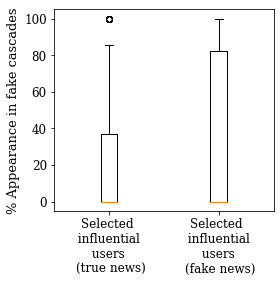

In [17]:
# dict_=pd.read_pickle('/meladyfs/newyork/krsharma/kdd_data/twitter-ma/tweet_dict_ids.pkl')
# dict_[list(dict_.keys())[0]]
fake_component = 0
output = "all_kwon/kwon"
data = "kwon"
output_dir = "../output/{}/".format(output)
edge_file = output_dir + 'learned_graph.tsv'
idx2u_file = output_dir + 'idx2u.txt'
selected_infl_file = output_dir + 'selected_influential_users.tsv'
data_dir = "../data/{}/".format(data)
cascades_file = data_dir + 'cascades.txt'
labels_file = data_dir + 'labels.txt'

df = pd.read_csv(edge_file, sep='\t')
idx2u = np.loadtxt(idx2u_file)
print('considered users in inference', len(idx2u))
train_cascades = read_cascades_file(cascades_file)
train_labels = np.loadtxt(labels_file)
print('num cascades', len(train_cascades), len(train_labels))
inf_df = pd.read_csv(selected_infl_file, sep='\t', header=0)
print('num selected infl', len(inf_df))

userfeat_file = '/meladyfs/newyork/krsharma/misc/kwon_dataset/sub_user_info_share.txt'
ufeat = pd.read_csv(userfeat_file, sep='\t', header=None) # followers, followees (friends), posts
ufeat.columns = ['userid', 'followers', 'friends/followees', 'posts']
# print(ufeat.head())

"""
First: Engagement count in user filtering
"""
def eng_count():
    true_cascades = np.array(train_cascades)[train_labels==0]
    fake_cascades = np.array(train_cascades)[train_labels == 1]
    # print('t/f', len(true_cascades), len(fake_cascades))

    u_t, u_f, sorted_t, sorted_f = get_engagement_counts(true_cascades, fake_cascades)
    # print('u_t, u_f, tot', len(u_t), len(u_f), len(u_t) + len(u_f))
    sorted_users = np.concatenate([sorted_t, sorted_f], axis=0)
    # users with engagements greater than 5
    num_users_with_large_eng = len(sorted_users[sorted_users[:, 1] > 5])
    # print('users large eng > 5', num_users_with_large_eng)
    num_users_with_large_eng = len(sorted_users[sorted_users[:, 1] > 10])
    # print('users large eng > 10', num_users_with_large_eng)
    
    return u_t, u_f

u_t, u_f = eng_count()

"""
Second: Find features of influential users selected. # followers, # posts, description # eng_t # eng_f
"""
fake_infl = inf_df['selected_{}'.format(fake_component)].apply(lambda x: int(idx2u[x]))
true_infl = inf_df['selected_{}'.format(1-fake_component)].apply(lambda x: int(idx2u[x]))

# list_fake = [572, 1907, 1932,  2621]
# list_true = [1976, 1921, 1896, 2080]
# fake_infl = [idx2u[f] for f in list_fake]
# true_infl = [idx2u[t] for t in list_true]

def extract_feats(infl, u_t, u_f):
    extracted_df = ufeat[ufeat['userid'].isin(infl)]
    extracted_df['u_t'] = extracted_df['userid'].apply(lambda x: u_t[x] if x in u_t else 0)
    extracted_df['u_f'] = extracted_df['userid'].apply(lambda x: u_f[x] if x in u_f else 0)
    extracted_df = extracted_df.set_index('userid').loc[infl]
    print(extracted_df.head(5))

print('-------> true infl feats\n')
extract_feats(true_infl, u_t, u_f)
print('-------> fake infl feats\n')
extract_feats(fake_infl, u_t, u_f)


"""
Second: Box plot of relative engagements
"""

# tma list_true = [182741872, 2388958777, 2580423060, 3438202888, 169954894, 1957558952, 64722130, 3212620271, 200435698, 582852483, 1389882727, 2416484101, 15521321, 3107909896, 1473389984, 3034853732, 540417242, 335461141, 1611858558, 125128428, 1280124271, 834953227, 248774714, 2886612620, 52865869, 49249409, 166206898, 15359014, 149981362, 2799603473, 1443132836, 922576634, 340789196, 138224000, 269334836, 3212596827, 1358201918, 321659355, 17703035, 123078358, 174102086, 3312233855, 631625137, 3272415836, 134240162, 765763200, 2203400720, 973546771, 724292641, 25236548, 104403350, 91609427, 267080200, 253633235, 947703439, 36539277, 1258761552, 588945219, 1229771844, 605487886, 90497896, 3081433067, 365214457, 15024705, 47332651, 622632971, 151579111, 499073057, 930575720, 576358484, 2376460524, 2338792994, 996430604, 2886787275, 127464003, 72882689, 2493044713, 486835275, 3177696986, 323515127, 973526730, 2591942665, 1703530184, 18085871, 17882093, 2904322704, 559437083, 3044646683, 21729540, 1258148130, 2942634366, 1073562656, 57388012, 435625148, 3349946379, 366974308, 77357964, 900732667, 505294099, 118024534]
# list_fake = [339429052, 15613203, 980941849, 210778303, 280122911, 386275837, 1662872534, 3044768385, 32658668, 546744362, 1624306176, 2203759645, 2385911990, 223432445, 2975722854, 3213005087, 46483345, 1383135966, 17115595, 73690963, 1652772608, 1036461709, 544380588, 247599114, 2408397397, 603440278, 3110930003, 384942394, 1424642856, 2388970874, 2388915241, 76908897, 374578350, 172106013, 427253416, 1160935351, 20850076, 30569506, 2538790446, 1938037314, 22225065, 1121790673, 370269230, 1484946193, 315577705, 308174015, 385394323, 3293377954, 1979279791, 3318477709, 2877872245, 1582545024, 243351447, 1526305728, 3177614538, 1253082505, 444898632, 52865869, 248774714, 1592407585, 3177760471, 186043413, 257517997, 456328773, 3177720054, 243264343, 190222885, 1181597546, 3044646683, 2203738322, 3040474978, 196264273, 975829939, 2215526899, 43600056, 1736506310, 626391901, 529622870, 2203707510, 31147225, 325327587, 717582870, 1572958224, 1557035341, 163364458, 2952724430, 1177641950, 32497478, 559799896, 2773297820, 507877806, 17285050, 2615420165, 51210644, 138221035, 603540902, 2956463164, 2209207302, 2362308738, 3212854007]

value_true, value_fake = get_relative_appearance_in_fake(u_t, u_f, true_infl[:50], fake_infl[:50])
box_plot_data=[value_true, value_fake]
pa = False  # patch artist
fig = plt.figure(figsize=(4, 4))
plt.boxplot(box_plot_data,labels=['Selected \n influential \n users \n (true news)','Selected \n influential \n users \n (fake news)'], patch_artist=pa)
plt.ylabel('% Appearance in fake cascades', fontsize=13)
# matplotlib.rcParams['xtick.labelsize'] = 15
# matplotlib.rcParams['ytick.labelsize'] = 15
# matplotlib.rcParams['figure.figsize'] = 15, 5

plt.tight_layout()
plt.show()
# plt.savefig("twitter_ma_selected_influential_users")

old_kwon = False

if old_kwon:
    print('Old Kwon')
    fake_infl = [42921853, 45696250, 9428477, 18485804, 37484955, 15538468, 34544545, 80876, 54879, 33361052, 37232745, 33603546, 1680247, 40864273, 134, 20164964, 29144327, 1883240, 47924370, 24916432, 35560818, 15554302, 773, 5272341, 29507615, 29156372, 38769438, 34345266, 2233, 8627533, 14611855, 32269208, 49726906, 28193335, 8098832, 12200968, 55903340, 47588713, 31917878, 19707732, 46248155, 33910097, 55976845, 27047346, 47386549, 9910421, 22678269, 44147043, 35379119, 51841996, 20795579, 37955867, 1002, 46900340, 48467139, 55970765, 17866088, 20853985, 21684, 55972805, 17281580, 18797761, 47872293, 22601310, 7148912, 43816406, 103535, 30331073, 27958549, 17119043, 34686602, 30721844, 28131892, 12068845, 18035830, 27104465, 22978489, 47977103, 46730321, 43369375, 43756699, 12186498, 19444022, 61280, 41050967, 31441663, 42926119, 55991030, 10688944, 16358632, 23219078, 5297007, 2150040, 35332369, 5773920, 68059, 42401663, 27547127, 15491837, 4667953]
    true_infl = [30122132, 9456, 1041957, 55931092, 52656642, 51298452, 2329550, 74679, 9761160, 42598690, 12987474, 1083172, 25480395, 24007123, 53616317, 6934529, 22041886, 25869801, 20510188, 37057701, 42946550, 23803578, 21417341, 31665361, 29264958, 16639123, 28117383, 5396879, 30971958, 23086420, 28776904, 80876, 40591, 49782598, 48911973, 10501473, 9022728, 11494548, 47350415, 55774980, 39515674, 42837, 17072, 49272331, 81419, 42760, 24058200, 10041, 30404702, 6365957, 11749083, 25672074, 14748530, 52263483, 166747, 45543326, 15315324, 20716299, 5903540, 34420488, 40075183, 23246755, 56017762, 43560260, 15191995, 33786128, 360451, 25200040, 16939, 23539100, 16759010, 56023202, 3420957, 9645533, 55935602, 41127254, 7414712, 54917, 52244910, 42976, 29156372, 24773084, 32106161, 35444685, 40176, 46945086, 54780470, 80877, 49755942, 19047950, 9656071, 38410, 11209421, 6481132, 49614, 35775165, 21719470, 22525981, 65561, 825]
    print('\n\n-------> true infl feats\n')
    extract_feats(true_infl, u_t, u_f)
    print('\n\n-------> fake infl feats\n')
    extract_feats(fake_infl, u_t, u_f)

    value_true, value_fake = get_relative_appearance_in_fake(u_t, u_f, true_infl, fake_infl)
    box_plot_data=[value_true, value_fake]

    fig = plt.figure(figsize=(4, 4))
    plt.boxplot(box_plot_data,labels=['Selected \n influential \n users \n (true news)','Selected \n influential \n users \n (fake news)'], patch_artist=pa)
    plt.ylabel('% Appearance in fake cascades', fontsize=13)
    # matplotlib.rcParams['xtick.labelsize'] = 15
    # matplotlib.rcParams['ytick.labelsize'] = 15
    # matplotlib.rcParams['figure.figsize'] = 15, 5

    plt.tight_layout()
    plt.show()
    # plt.savefig("twitter_ma_selected_influential_users")


# assume 80% chance that the cascade belongs to true comp
# 20% fake  = a does influence b (but on true theta only)
# puv_T = updated by cascade
# puv_F = updated by cascade
# so even if someone is not very influential but really fake, we wont see him over these

# u2idx = dict(zip(idx2u, np.arange(len(idx2u))))
# user = u2idx[45357704]  # u2idx[39357] 
# edf = df[df['u'].isin([user])]
# edf.columns = ['u', 'v', 'act_fake', 'act_true']